In [31]:
import SimpleITK as sitk, numpy as np
import torch, nrrd, pandas as pd, monai.metrics as met

In [32]:
data = data = pd.read_csv('/Users/joemarsilla/Downloads/pred/hnscc3dct/manifest_updated_ref.csv', index_col=0)

In [13]:
len(data)

174

In [14]:
pats = list(data['0'])

In [20]:
p = [p.split('/')[-2].partition('.')[0] for p in pats]

In [7]:
p = list(set(p))

In [21]:
from collections import OrderedDict
p = OrderedDict((x, True) for x in p).keys()

In [22]:
p = list(p)

In [23]:
p

['HN_P001_0',
 'HN_P001_1',
 'HN_P001_2',
 'HN_P002_0',
 'HN_P002_1',
 'HN_P002_2',
 'HN_P003_2',
 'HN_P004_0',
 'HN_P004_1',
 'HN_P004_2',
 'HN_P005_0',
 'HN_P005_1',
 'HN_P005_2',
 'HN_P007_0',
 'HN_P007_1',
 'HN_P007_2',
 'HN_P008_0',
 'HN_P008_1',
 'HN_P008_2',
 'HN_P009_0',
 'HN_P009_1',
 'HN_P009_2',
 'HN_P010_0',
 'HN_P010_1',
 'HN_P010_2',
 'HN_P011_0',
 'HN_P011_1',
 'HN_P011_2',
 'HN_P012_0',
 'HN_P012_1',
 'HN_P012_2',
 'HN_P013_0',
 'HN_P013_1',
 'HN_P013_2',
 'HN_P014_0',
 'HN_P014_1',
 'HN_P014_2',
 'HN_P015_0',
 'HN_P015_1',
 'HN_P015_2',
 'HN_P016_0',
 'HN_P016_1',
 'HN_P016_2',
 'HN_P017_0',
 'HN_P017_1',
 'HN_P017_2',
 'HN_P018_0',
 'HN_P018_1',
 'HN_P018_2',
 'HN_P019_0',
 'HN_P019_1',
 'HN_P019_2',
 'HN_P020_1',
 'HN_P022_0',
 'HN_P022_1',
 'HN_P022_2',
 'HN_P023_0',
 'HN_P023_1',
 'HN_P023_2',
 'HN_P024_0',
 'HN_P024_1',
 'HN_P024_2',
 'HN_P026_0',
 'HN_P026_1',
 'HN_P026_2',
 'HN_P027_0',
 'HN_P027_1',
 'HN_P027_2',
 'HN_P028_0',
 'HN_P028_1',
 'HN_P028_2',
 'HN_P

In [24]:
pddca_classes = ['BrainStem', 'Chiasm', 'Mandible', 'OpticNerve_L', 'OpticNerve_R', 'Parotid_L', 'Parotid_R']
# deep_classes2 = ['Brainstem','Lens_Lt', 'Lens_Rt', 'Mandible', 'Optic_Nerve_Lt', 'Optic_Nerve_Rt', 'Parotid_Lt', 'Parotid_Rt', 'Orbit_Lt', 'Orbit_Rt', 'Spinal_Cord', 'Spinal_Canal']
index_ = [1, 18, 5, 16, 17, 6, 7]
chosen = ['BSTEM','SPCOR','ESOPH','LARYNX','MAND','LPAR','RPAR','LACOU','RACOU','RPLEX','LPLEX','LLENS','RLENS','LEYE','REYE','LOPTIC','ROPTIC','CHIASM','LIPS']

In [25]:
len(index_)

7

In [26]:
len(pddca_classes)

7

In [27]:
# import torch, numpy as np, warnings
# this is the function to one-hot-encode data
def onehot(outs, targ, argmax=True):
    # Metrics requiring one hot encoded targets, pass through sigmoid or softmax
    # convert to one hot encoded target...
    shape = targ.size()
    print(len(shape), shape, outs.size())
    batch = shape[0]
    # calculate argmax...
    if argmax is True:
        outs = torch.softmax(outs, dim=1)
        outs = torch.argmax(outs, dim=1)
    
    class_ = int(torch.max(targ).item())
    print(class_)
    
    if len(shape) == 4:
        sh = (batch, class_ + 1, shape[1], shape[2], shape[3])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)
    else:
        sh = (1, class_ + 1, shape[0], shape[1], shape[2])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)

    for i in range( class_ + 1):
        targets_dice[0, i][targ[0] == i] = 1
        targets_out[0, i][outs[0] == i] = 1

    return targets_out, targets_dice


In [28]:
def resample_sitk(image, mode="linear", new_spacing=None, filter=False ): # new_spacing=np.array((1.0, 1.0, 2.0)) , filter=True
    if new_spacing is not None: # originally taken from https://github.com/SimpleITK/SimpleITK/issues/561
        resample = sitk.ResampleImageFilter()
        if mode == "linear":
            resample.SetInterpolator = sitk.sitkLinear  # use linear to resample image
        else: # use sitkNearestNeighbor interpolation # best for masks
            resample.SetInterpolator = sitk.sitkNearestNeighbor
        orig_size = np.array(image.GetSize(), dtype=np.int)
        orig_spacing = np.array(image.GetSpacing())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(image.GetOrigin())
        resample.SetOutputPixelType(image.GetPixelIDValue())
        new_spacing = new_spacing
        resample.SetOutputSpacing(new_spacing)
        new_size = orig_size * (orig_spacing / new_spacing)
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(s) for s in new_size]
        resample.SetSize(new_size)
        if filter is True: # fights artifacts produced by analaising # only do this when resampling image (not mask...)
            img = resample.Execute(sitk.SmoothingRecursiveGaussian(image, 2.0))
        else:
            img = resample.Execute(image)
    else: # do nothing to the image...
        img = image
    return img

In [108]:
oars = []
dce =  []
hd =   []
sd =   []
p_ = []

In [ ]:
# path of folders...
# observer = 'radiographer'
path = f'/Users/joemarsilla/Downloads/data/HNSCC-3DCT-RT/' 

for i, pat in enumerate(p):
    path_ = path+pat+'/structures/'
    # load subsequent patient outputs from model...
    out_path = f"/Users/joemarsilla/Downloads/pred/hnscc3dct/FINAL_/outs_{i}_FULL.nrrd"
    # outputs = torch.from_numpy(np.load(out_path))
    outputs = torch.from_numpy(nrrd.read(out_path)[0])
#     targets = torch.from_numpy(np.load(out_path.replace('outs', 'in')))
    outputs, _ = onehot(outputs.unsqueeze(0), outputs.unsqueeze(0), argmax=False)
    try:
        for k, val in enumerate(chosen):
            try:
                targ = sitk.ReadImage(path_+val+'.nrrd')
                targ = sitk.GetArrayFromImage(targ)
                shape = targ.shape
        #       img = self.resample_sitk(img, new_spacing=np.array((1.0, 1.0, 2.0)))
        #         targ = resample_sitk(targ, mode="nearest", new_spacing=np.array((1.0, 1.0, 2.0)))
                # tsize = targ.size()
                # print(tsize)
                # outs = outputs[0,val]
                # osize = outs.size()
                # if osize[0] != tsize[0]:
                #     diff = osize[0] - tsize[0]
                #     a = diff//2
                #     difff = diff - a
                #     outs = outs[a:osize[0]-difff]
                #     osize = outs.size()
                #     assert osize[0] == tsize[0]
                targ = torch.tensor(targ[shape[0]//5:shape[0]-shape[0]//6])
                outs = outputs[0,k+1,shape[0]//5:shape[0]-shape[0]//6]
                dc = met.compute_meandice(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0))
                h  = met.compute_hausdorff_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), percentile=95, include_background=False)
                s  = met.compute_average_surface_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), include_background=False)
                print(val, dc, h)
                # save metrics...
                dce.append(dc[0][0].item())
                hd.append(h[0][0].item())
                sd.append(s[0][0].item())
        #         ob.append(observer)
#                 pddca_oars.append(pddca_classes[k])
                oars.append(val)
                p_.append(pat)
            except Exception as e:
                print(e)
                print(f'No {val} in {p[i+13]}')
    except Exception as e:
        print(e)
        print(pat, ' is BAD.')

4 torch.Size([1, 198, 512, 512]) torch.Size([1, 198, 512, 512])
19
(1, 20, 198, 512, 512)
BSTEM tensor([[0.8841]]) tensor([[3.1623]], dtype=torch.float64)
SPCOR tensor([[0.8062]]) tensor([[2.]], dtype=torch.float64)
Exception thrown in SimpleITK ImageFileReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/Users/joemarsilla/Downloads/data/HNSCC-3DCT-RT/HN_P001_0/structures/ESOPH.nrrd" does not exist.
No ESOPH in HN_P007_0
Exception thrown in SimpleITK ImageFileReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/Users/joemarsilla/Downloads/data/HNSCC-3DCT-RT/HN_P001_0/structures/LARYNX.nrrd" does not exist.
No LARYNX in HN_P007_0
MAND tensor([[0.8208]]) tensor([[5.]], dtype=torch.float64)
LPAR tensor([[0.5931]]) tensor([[12.8062]], dtype=torch.float64)
RPAR tensor([[0.5914]]) tensor([[9.8995]], dtype=torch.float64)
LACOU tensor([[0.2516]]) tensor([[7.6811]], dtype=torch.float64)
RA

In [78]:
i

74

In [38]:
# img = np.load('/Users/joemarsilla/Downloads/hnscc_ai_preds/outs_83_FULL.npy')
img = nrrd.read('/Users/joemarsilla/Downloads/pred/hnscc3dct/FINAL_/outs_0_FULL.nrrd')[0]

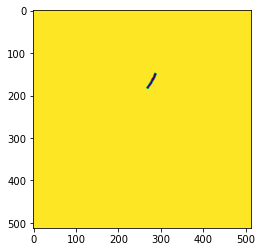

In [73]:
import matplotlib.pyplot as plt
sl = img[148]!=16
plt.imshow(sl)

In [60]:
outs[50].max()

tensor(1.)

In [73]:
im = sitk.ReadImage('/Users/joemarsilla/Downloads/HNSCC-3DCT-RT/HN_P001_1/structures/GTV.nrrd')

In [75]:
im = sitk.GetArrayFromImage(im)

In [32]:
path_+val+'.nrrd'

'/Users/joemarsilla/Downloads/HNSCC-3DCT-RT/1/structures/LIPS.nrrd'

In [61]:
len(oars)

307

In [ ]:
data_ = {}
data_['OAR'] = oars
# data_['OAR_PDDCA'] = pddca_oars
data_['Patient'] = p_
data_['VolDice'] = dce
data_['95HD'] = hd
data_['SurfDice'] = sd
# data_['Observer'] = ob

In [ ]:
data_ = pd.DataFrame.from_dict(data_)
data_.to_csv('/Users/joemarsilla/OARensemble2021_hnscc3drt2.csv')
data_
# data_['OAR'] = data_['OAR'].fillna("CHIASM")
# data_.to_csv('/Users/joemarsilla/OARensemble2021_pddca.csv')

In [96]:
data_[data_['OAR'] == "CHIASM"]
# images of different sizes (sliding window must be different)
# exclude = ['0522c0727b', '0522c0727a']

,OAR,Patient,VolDice,95HD,SurfDice
9,CHIASM,HN_P001_0,0.010035,11.532563,3.259063
21,CHIASM,HN_P001_2,0.000000,11.789826,3.374559
49,CHIASM,HN_P002_2,0.082386,8.224460,1.854403
58,CHIASM,HN_P003_2,0.308943,6.164414,1.390603
68,CHIASM,HN_P004_0,0.225634,7.348469,2.418540
...,...,...,...,...,...
696,CHIASM,HN_P027_1,0.314607,6.403124,2.185870
707,CHIASM,HN_P027_2,0.287370,9.197787,3.356562
721,CHIASM,HN_P028_0,0.141935,7.183033,2.803024
735,CHIASM,HN_P028_1,0.078431,8.124038,3.291469


In [97]:
data_

,OAR,Patient,VolDice,95HD,SurfDice
0,BSTEM,HN_P001_0,0.884096,3.162278,0.891206
1,SPCOR,HN_P001_0,0.806170,2.000000,0.956404
2,MAND,HN_P001_0,0.820791,5.000000,1.300482
3,LPAR,HN_P001_0,0.593148,12.806248,3.654126
4,RPAR,HN_P001_0,0.591432,9.899495,3.530060
...,...,...,...,...,...
783,SPCOR,HN_P034_0,0.853327,2.000000,0.785836
784,BSTEM,HN_P034_1,0.861377,2.828427,0.938992
785,SPCOR,HN_P034_1,0.892097,1.414214,0.557894
786,BSTEM,HN_P034_2,0.848786,3.741657,1.096775


In [66]:
# fdata = data_[~data_.Patient.isin(exclude)]
# exclude = ['Spinal-Canal']
# fdata = fdata[~fdata.OAR_Deepmind.isin(exclude)]

In [67]:
# fdata

In [85]:
import matplotlib.pyplot as plt
import seaborn as sea

In [ ]:
# NOT CORRECTED
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set1")
plt.title('3D Volumetric Dice (HNSCCC-3D-CT Test Set, WOLNET)\n', fontsize=120)
rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'LOPTIC', 'ROPTIC', 'LIPS','CHIASM']
# rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'RLENS', 'LACOU', 'RACOU', 'LPLEX', 'RPLEX', 'LIPS', 'LOPTIC', 'ROPTIC', 'CHIASM']
data_.OAR = data_.OAR.astype("category")
data_.OAR.cat.set_categories(rois, inplace=True)
data_.sort_values(["OAR"])
medians = data_.groupby(['OAR'])['VolDice'].median()
vertical_offset = data_['VolDice'].median() * 0.075 # offset from median for display
ax = sea.boxplot(data=data_, x="OAR", y="VolDice", hue="OAR", hue_order=rois, width=.85, linewidth=3,  dodge=False) # hue_order=chosen,
ax.set_xticklabels(rois, rotation=60, fontsize=80)
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='3D Volumetric Dice\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('3D Volumetric Dice\n', fontsize=100)
# ax.legend_.remove()

posx and posy should be finite values
posx and posy should be finite values


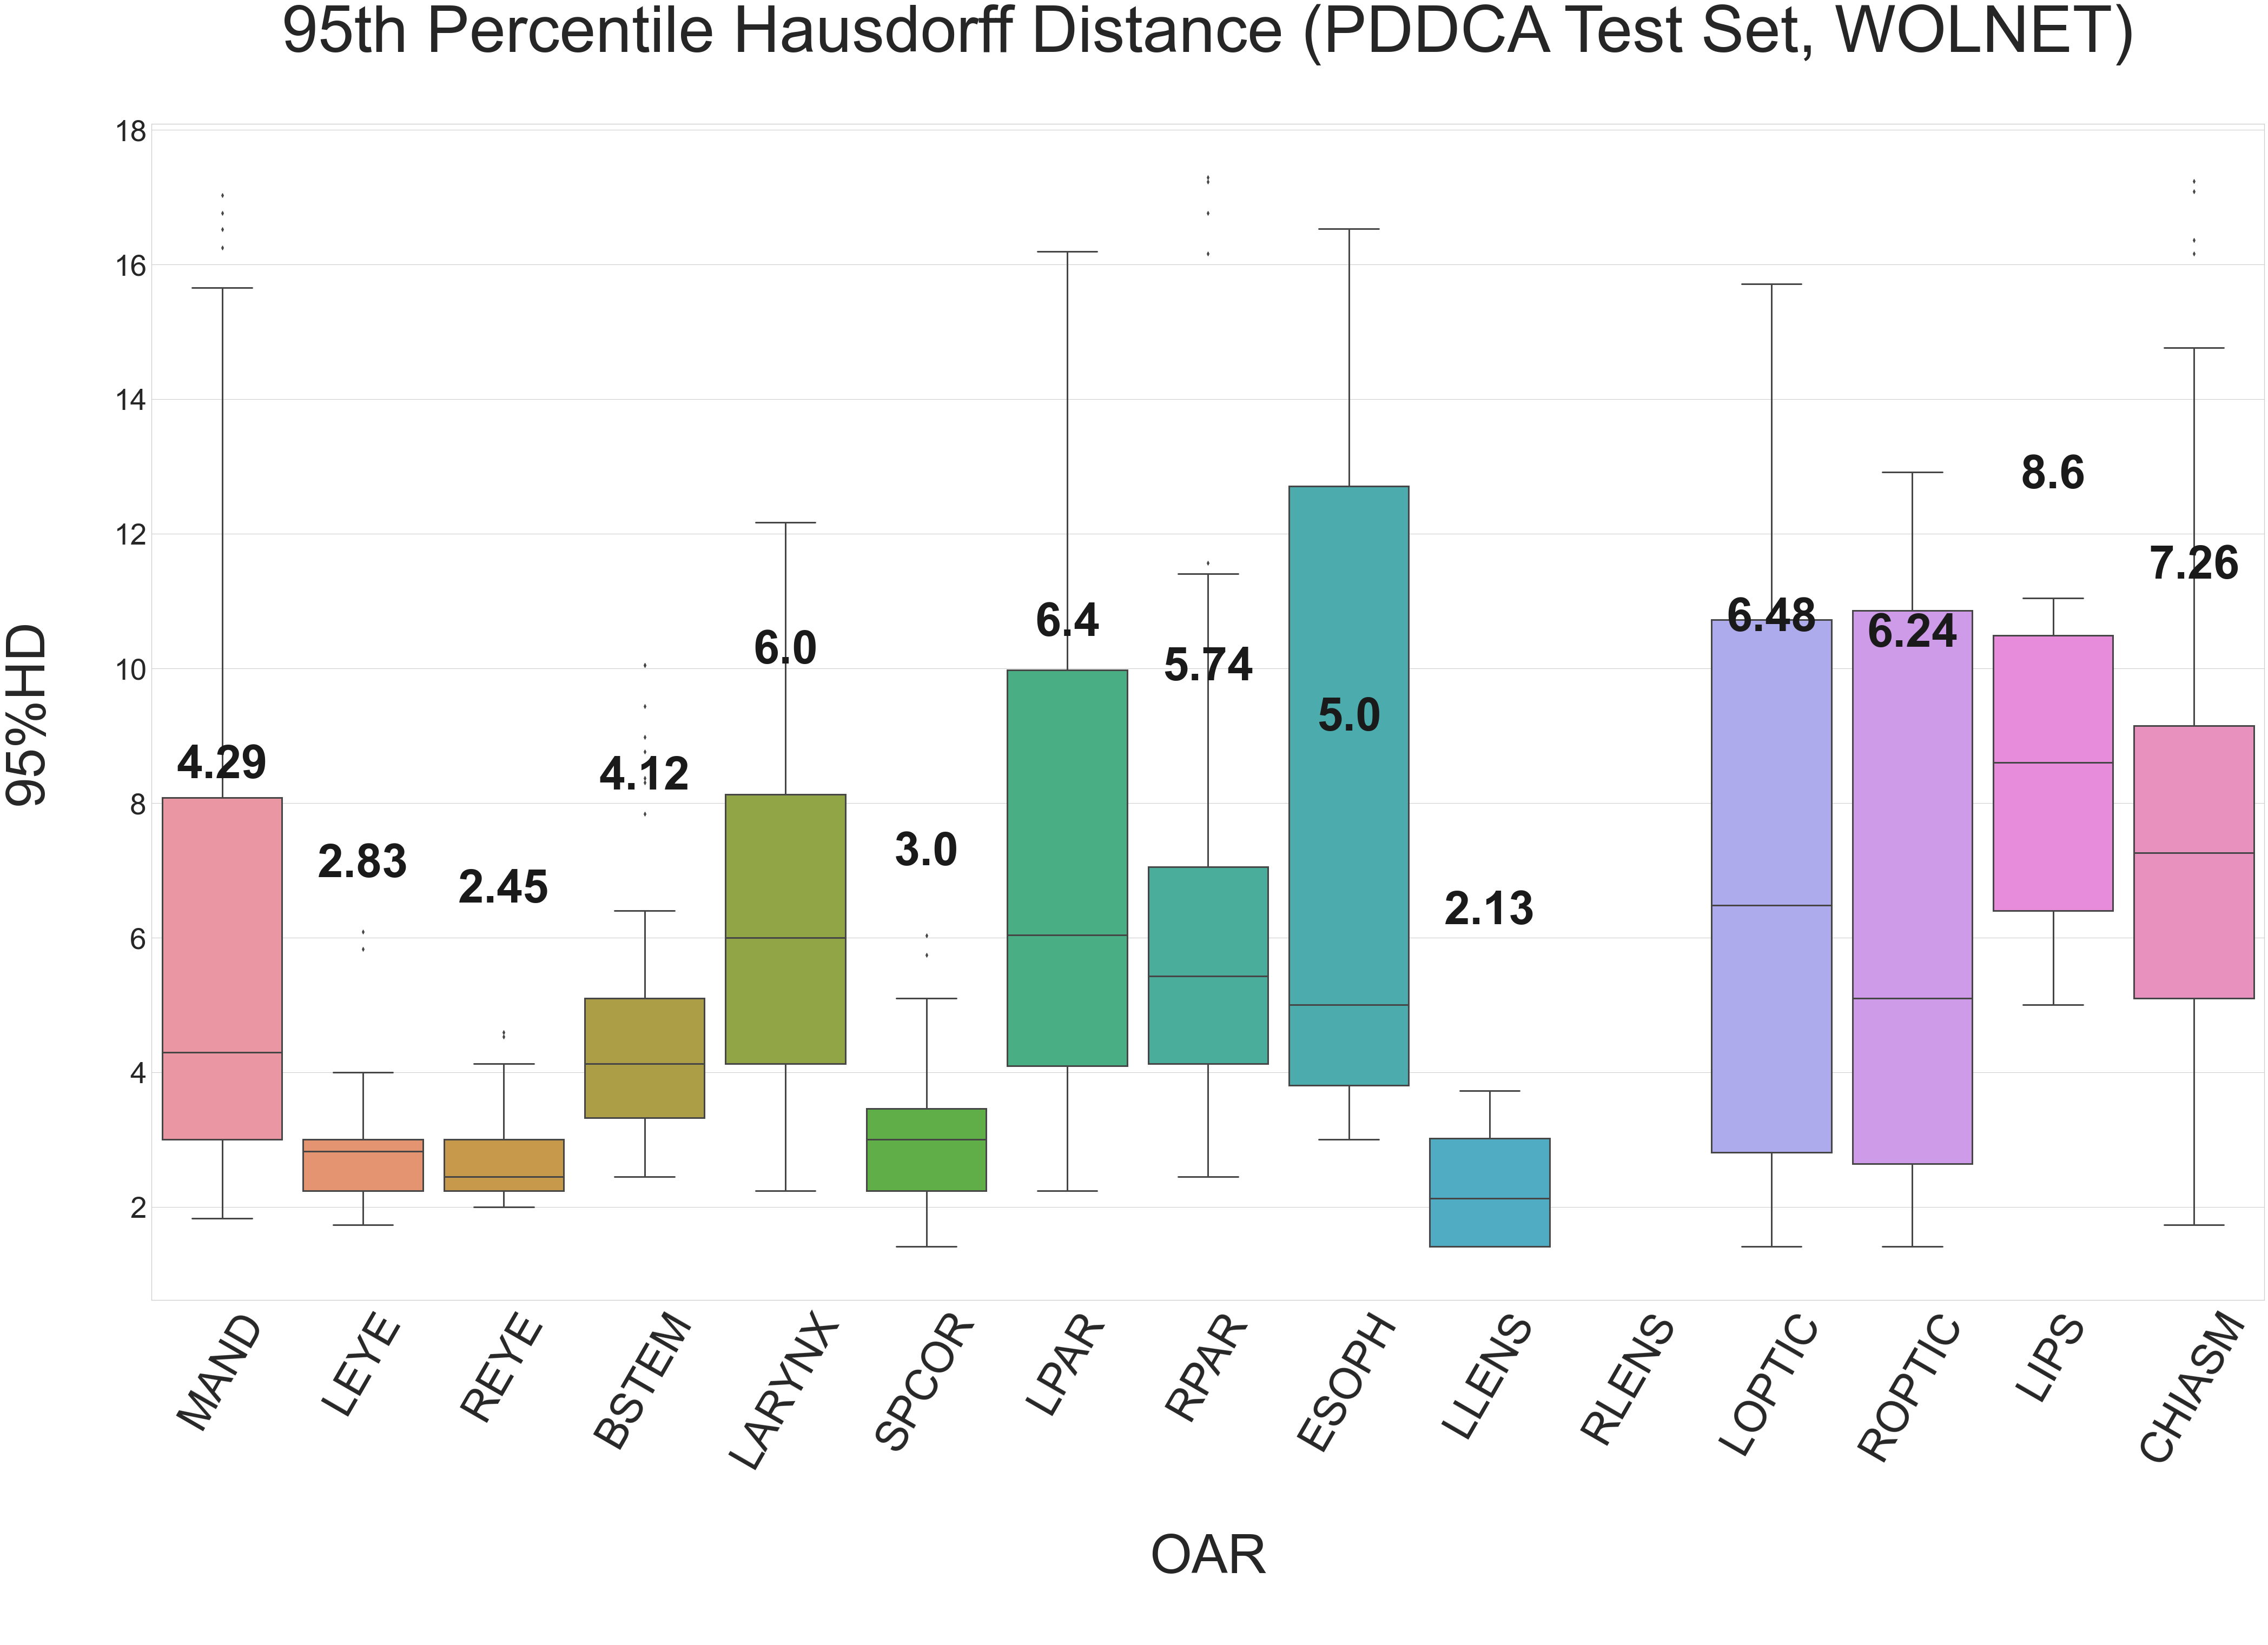

In [107]:
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('95th Percentile Hausdorff Distance (PDDCA Test Set, WOLNET)\n', fontsize=120)
ax = sea.boxplot(data=data_[data_["95HD"]<17.5], x="OAR", y="95HD", hue="OAR",hue_order=rois, width=.85, linewidth=3, dodge=False)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
medians = data_.groupby(['OAR'])['95HD'].median()
vertical_offset = data_['95HD'].median() * .8 # offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='95%HD\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('95%HD\n', fontsize=100)
ax.legend_.remove()

In [100]:
# testing files..
outs = np.load('/Users/joemarsilla/Downloads/hnscc_ai_preds/outs_53_FULL.npy')

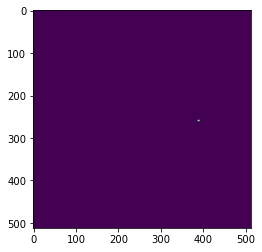

0


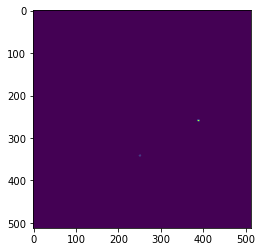

1


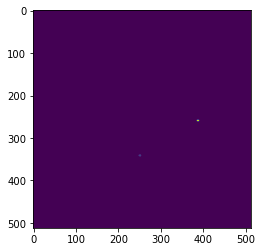

2


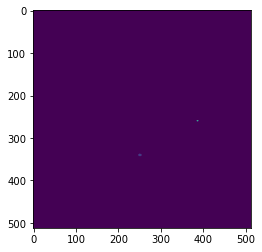

3


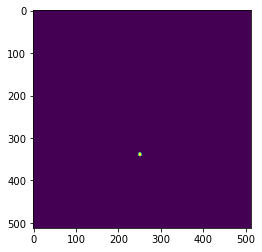

4


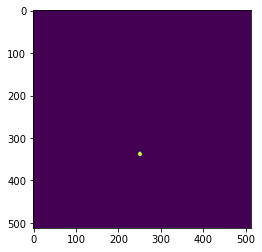

5


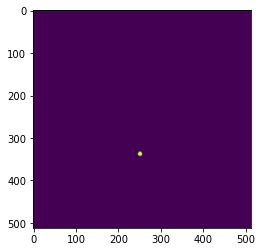

6


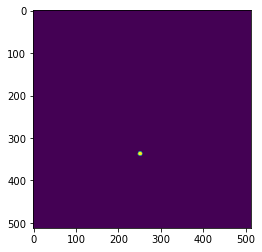

7


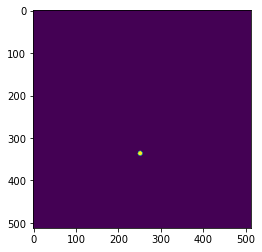

8


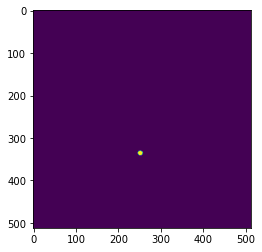

9


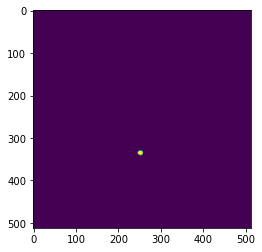

10


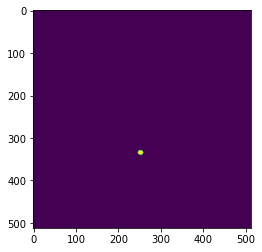

11


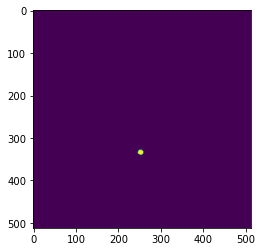

12


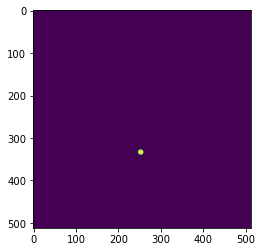

13


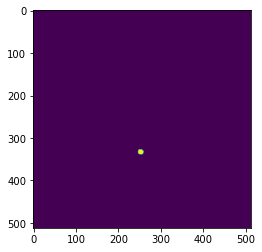

14


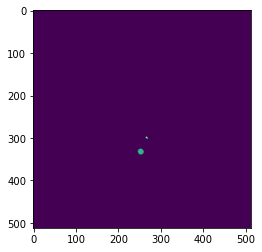

15


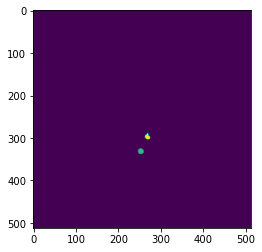

16


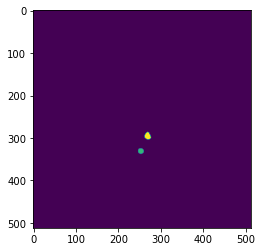

17


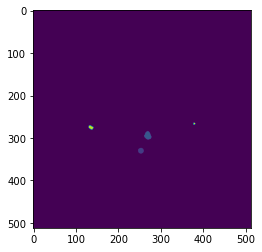

18


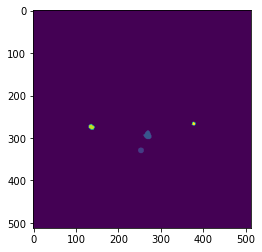

19


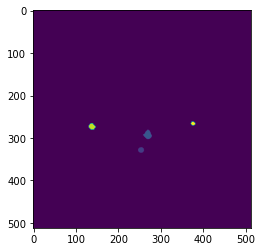

20


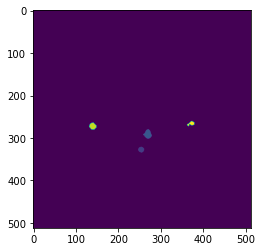

21


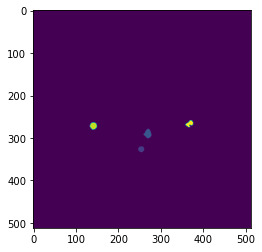

22


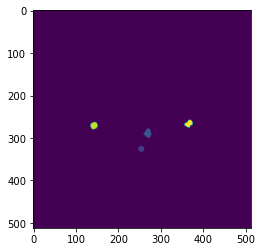

23


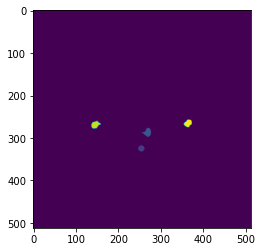

24


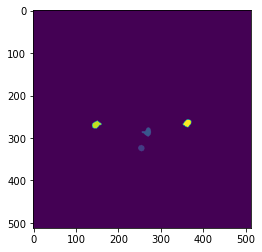

25


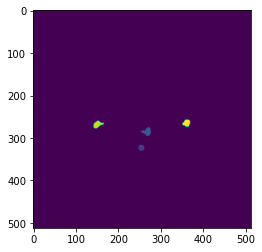

26


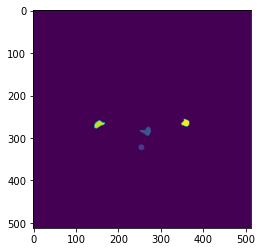

27


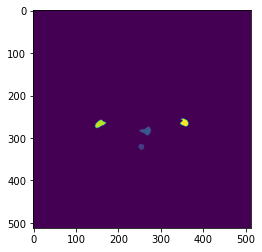

28


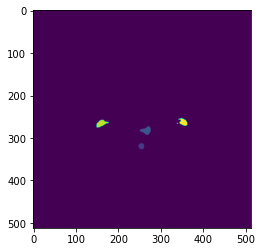

29


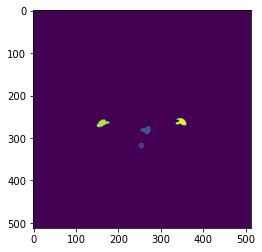

30


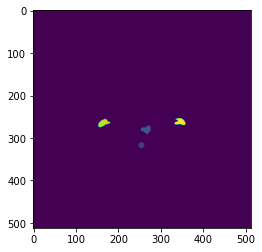

31


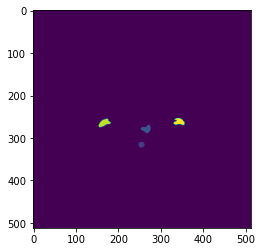

32


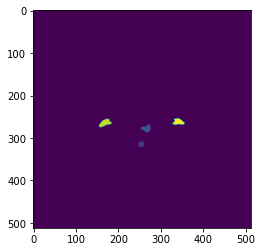

33


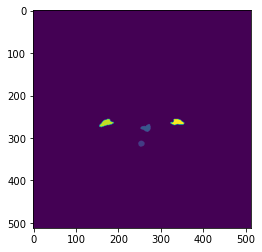

34


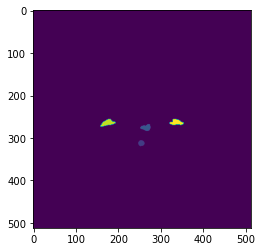

35


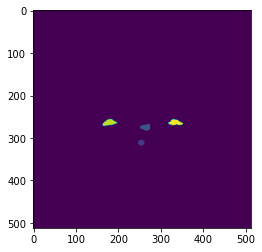

36


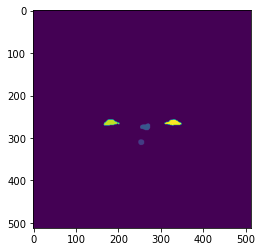

37


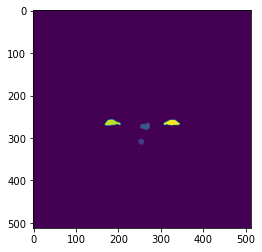

38


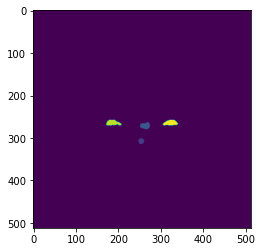

39


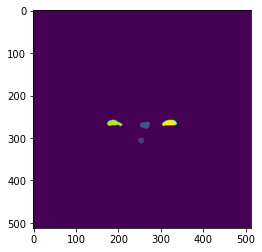

40


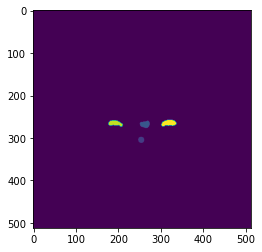

41


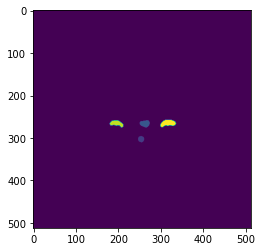

42


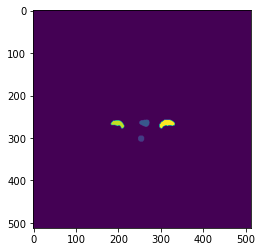

43


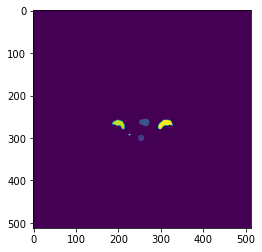

44


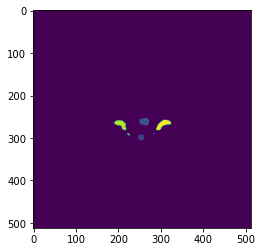

45


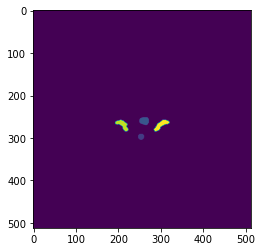

46


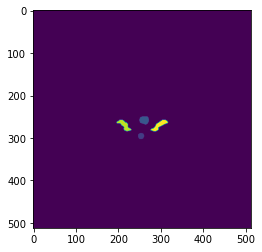

47


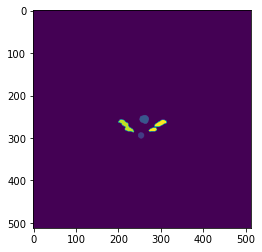

48


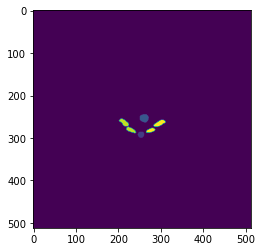

49


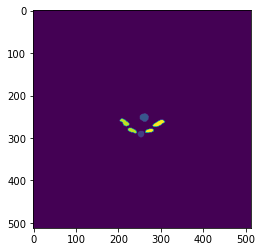

50


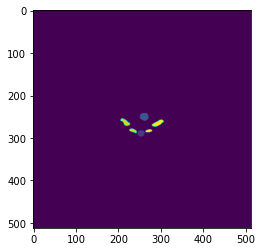

51


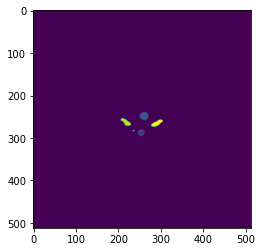

52


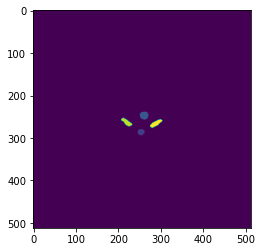

53


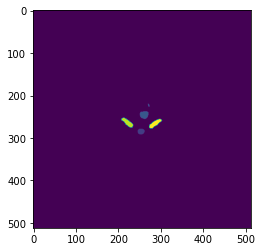

54


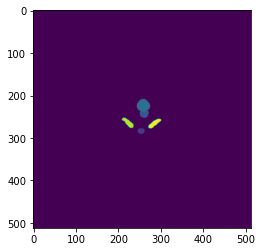

55


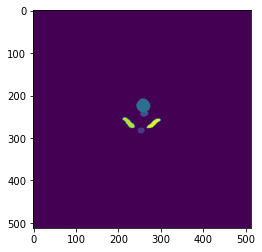

56


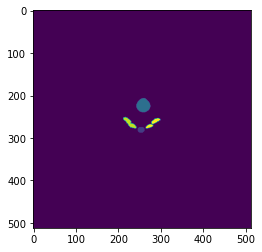

57


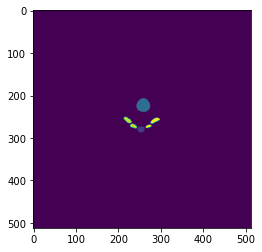

58


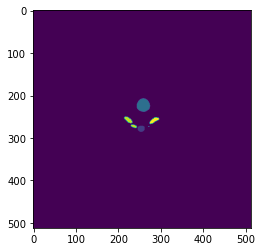

59


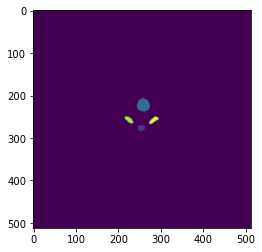

60


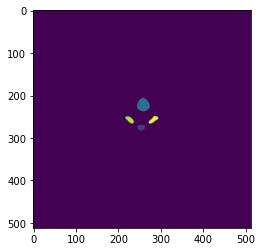

61


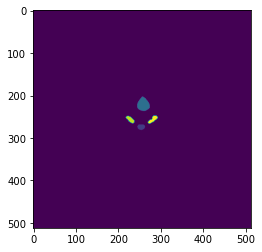

62


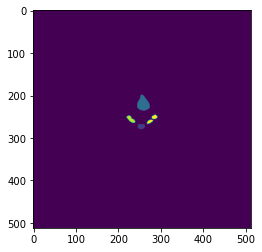

63


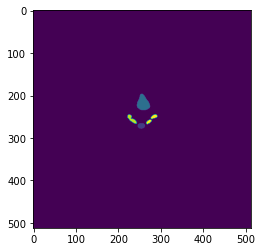

64


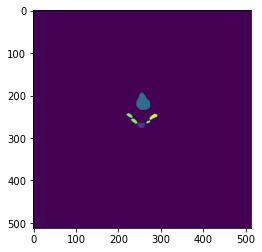

65


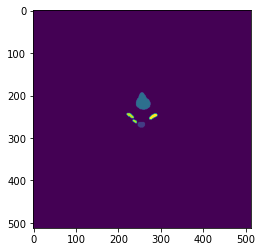

66


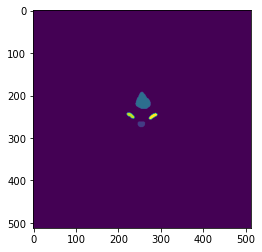

67


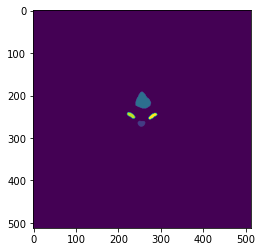

68


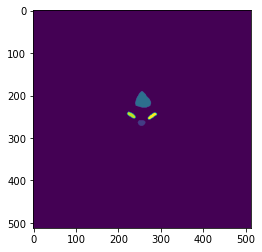

69


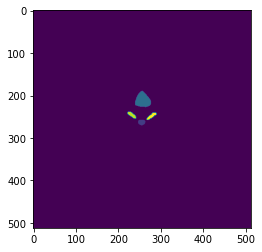

70


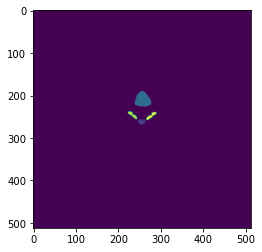

71


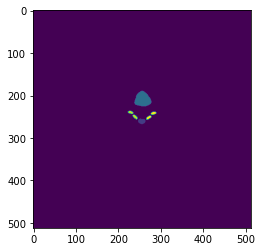

72


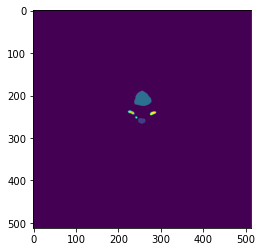

73


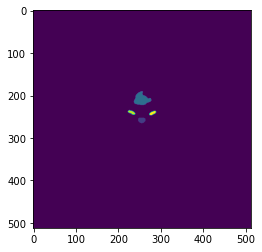

74


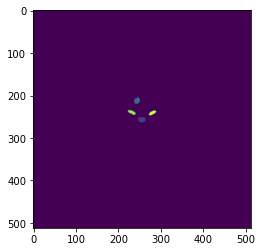

75


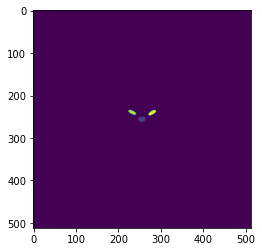

76


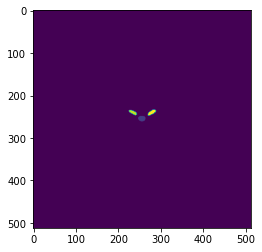

77


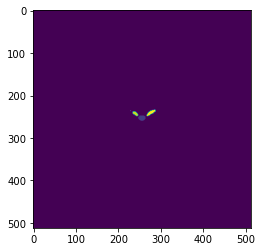

78


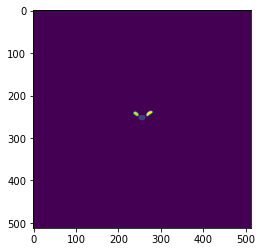

79


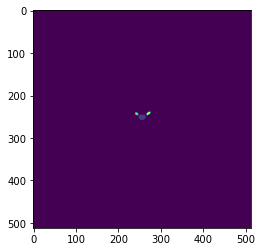

80


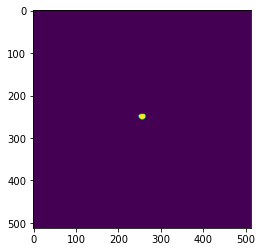

81


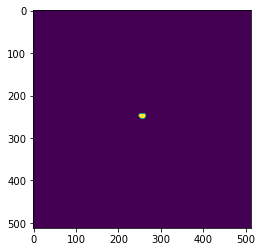

82


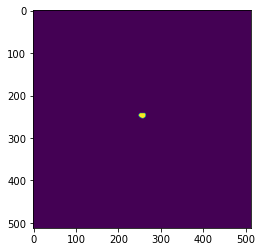

83


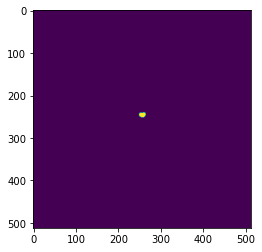

84


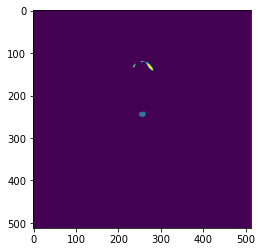

85


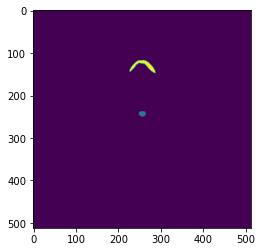

86


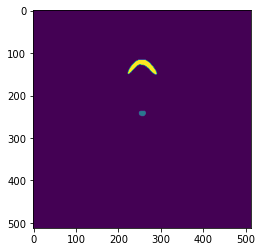

87


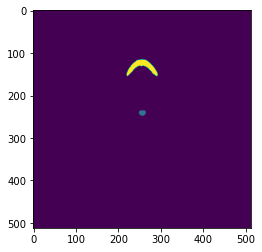

88


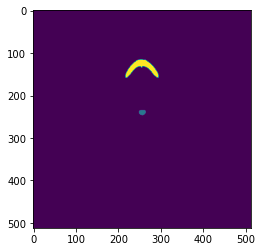

89


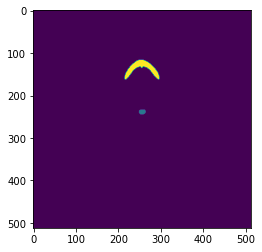

90


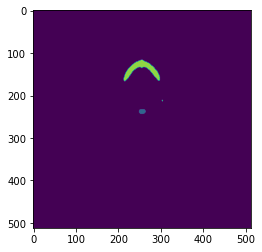

91


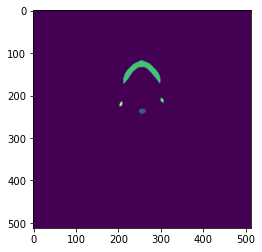

92


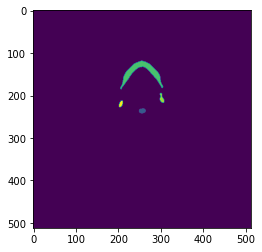

93


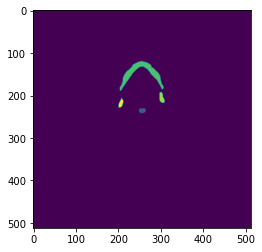

94


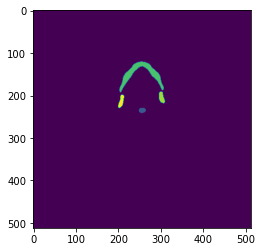

95


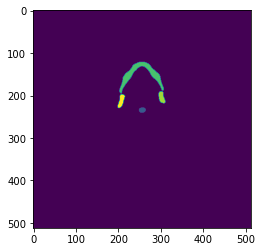

96


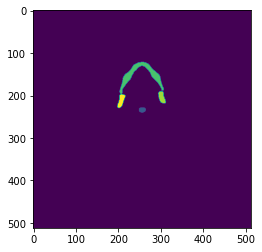

97


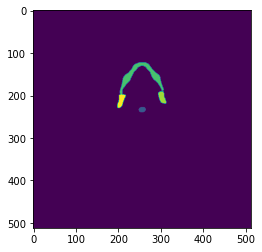

98


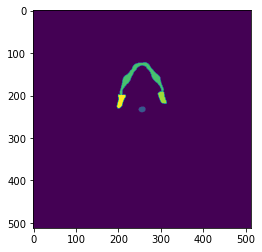

99


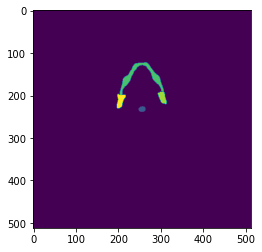

100


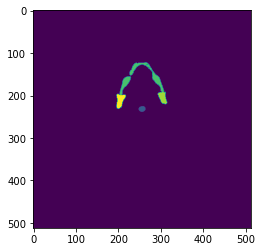

101


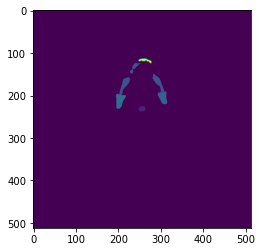

102


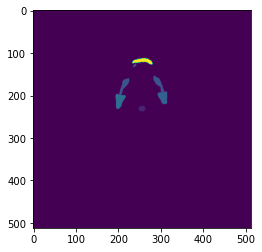

103


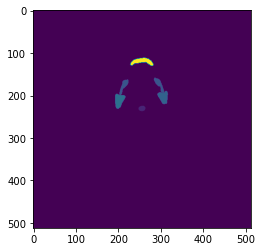

104


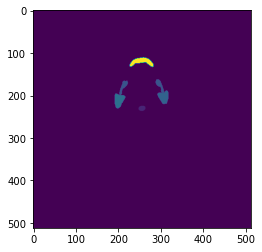

105


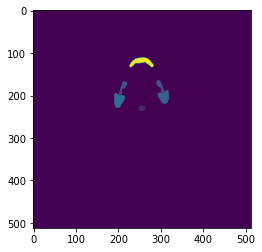

106


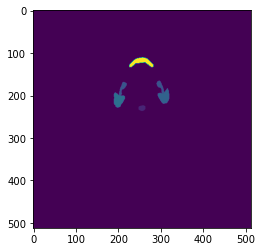

107


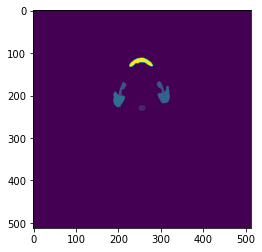

108


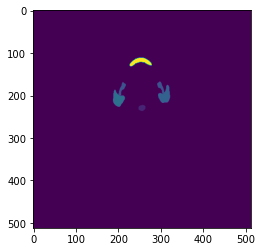

109


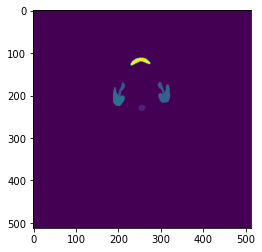

110


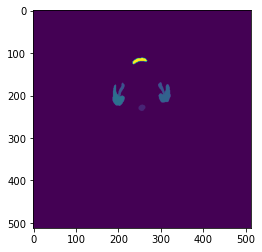

111


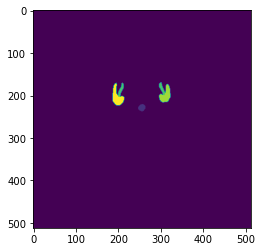

112


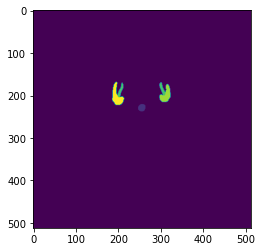

113


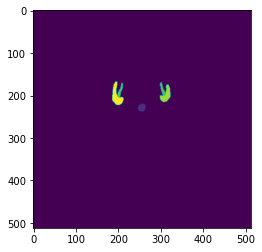

114


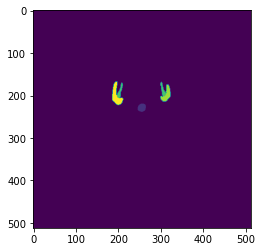

115


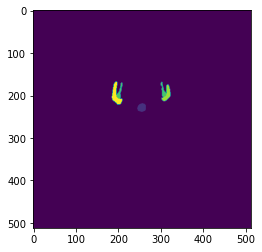

116


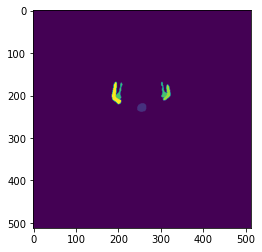

117


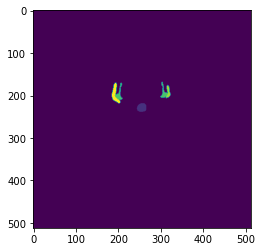

118


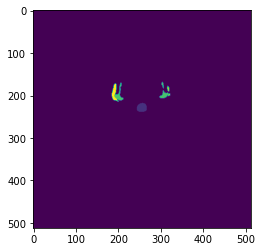

119


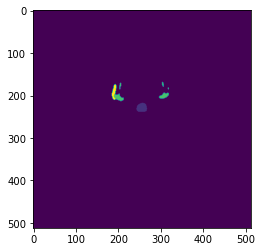

120


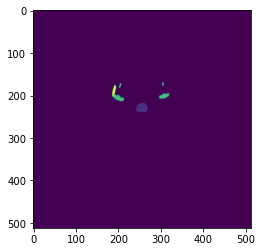

121


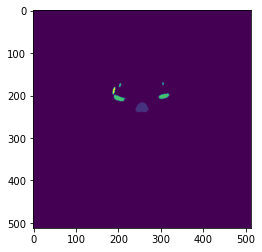

122


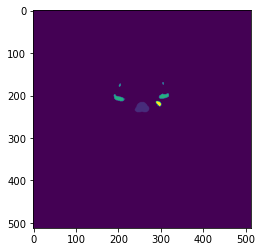

123


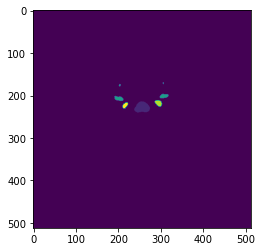

124


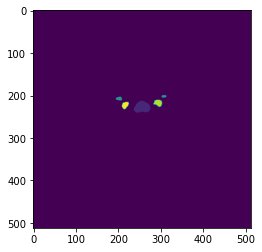

125


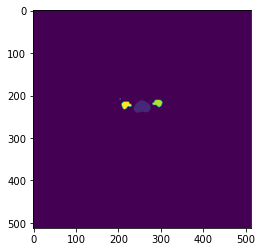

126


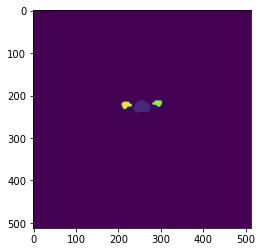

127


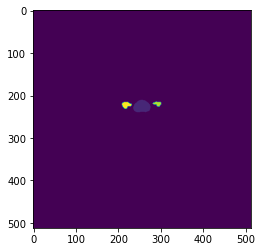

128


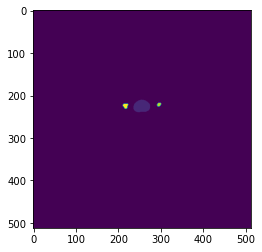

129


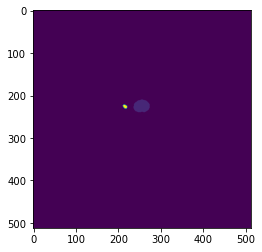

130


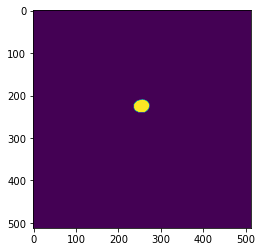

131


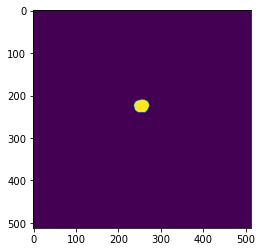

132


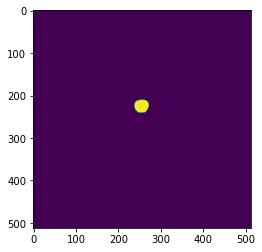

133


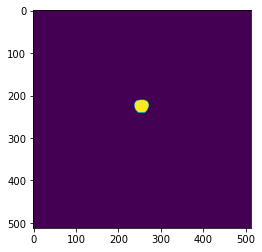

134


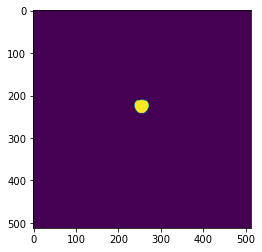

135


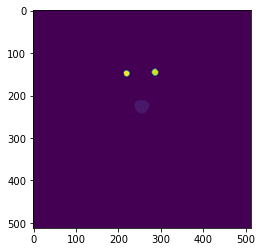

136


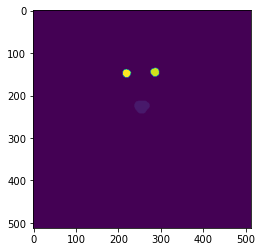

137


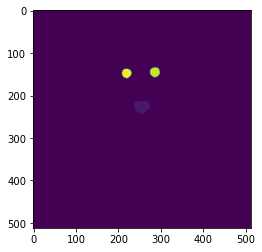

138


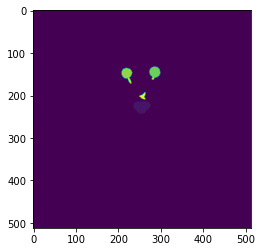

139


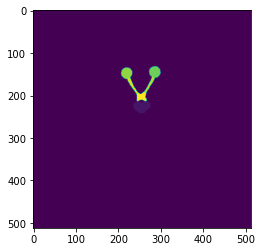

140


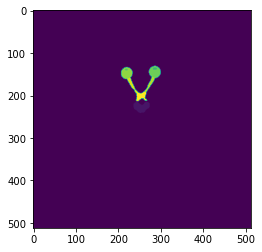

141


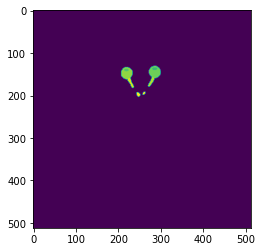

142


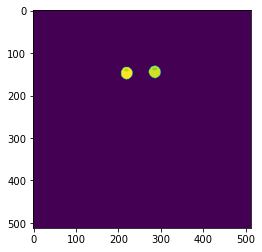

143


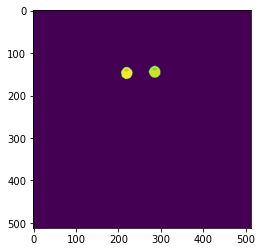

144


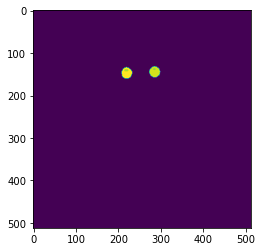

145


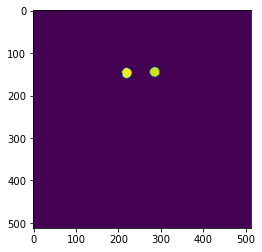

146


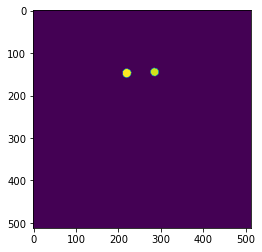

147


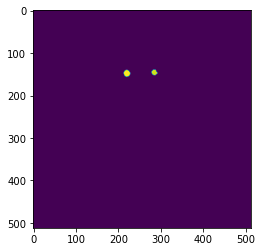

148


In [103]:
for i, slice_ in enumerate(outs):
    if slice_.max() > 0:
        plt.imshow(slice_)
        plt.show()
        print(i)